# <center>Exoplanets<center>

**Exoplanet** (EK-soh-plan-it): A planet that revolves around a star other than the Sun.

In [1]:
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import scale

%matplotlib inline
plt.style.use("ggplot")

In [2]:
url_base = "http://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?format=json"

This research has made use of the [NASA Exoplanet Archive](http://exoplanetarchive.ipac.caltech.edu/index.html), which is operated by the California Institute of Technology, under contract with the National Aeronautics and Space Administration under the Exoplanet Exploration Program.

This source has the most current official NASA information available. Becuase the data is in flux, some other sources may be out of date, and thus they may disagree with this information. It's also possible that other sources may disagree with NASA's definitions in vague situations, and thus have slightly different data for edge cases.

# Discovery

In [3]:
# Get data about the discovery of the planets
query = url_base + "&table=exoplanets&select=pl_discmethod,pl_disc,pl_facility,pl_locale,pl_rade"
discovery = pd.DataFrame(requests.get(query).json())

In [4]:
# Clean up improperly capitalized data
for row in discovery[discovery["pl_facility"] == "kepler"].iterrows():
    discovery.ix[row[0], "pl_facility"] = row[1]["pl_facility"].capitalize()

### How many planets have we found orbiting other stars so far?

In [5]:
print("Number of confirmed exoplanets: %d" % len(discovery))

Number of confirmed exoplanets: 3272


### When were they found?

In [6]:
print("Earliest discovery: %d" % discovery["pl_disc"].min())

Earliest discovery: 1989


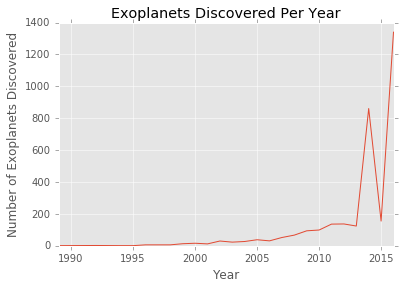

In [7]:
discovery.groupby("pl_disc").size().plot()
plt.xlabel("Year")
plt.ylabel("Number of Exoplanets Discovered")
plt.title("Exoplanets Discovered Per Year")

Having confirmation that exoplanets even exist is a relatively new idea. The first one wasn't discovered until 1989, but in the time since, the number of exoplanets we know of has exploded.

### How are exoplanets discovered?

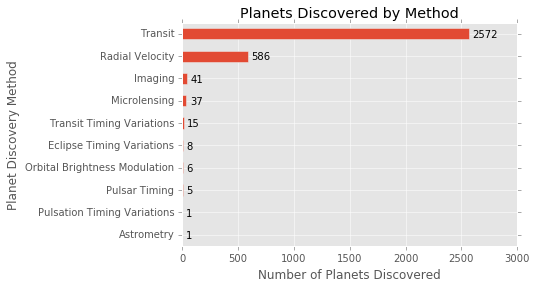

In [8]:
# Analyze the discovery methods
disc_method = discovery.groupby("pl_discmethod").size().sort_values()

# Plot method frequencies
ax = disc_method.plot.barh()
plt.xlabel("Number of Planets Discovered")
plt.ylabel("Planet Discovery Method")
plt.title("Planets Discovered by Method")

# Include count labels on bar graph
for rect, label in zip(ax.patches, disc_method):
    ax.text(rect.get_width() + 30, rect.get_y(), label, va="bottom")

Many methods have been proposed to find exoplanets, but only 10 have ever been successfully used (by NASA's definitions).

What the methods are:
- **Transit:** Analyzing how the star dims when the planet passes between us and the star.
- **Radial Velocity:** Using the Doppler effect to measure how much the planet's gravity makes the star wobble. Used to discover the first exoplanet in 1989.
- **Imaging:** Taking a picture of the planet.
- **Microlensing:** Detecting planet's gravity's effect on the star's light.
- **Transit Timing Variations:** Finding additional planets in a solar system through variations in an already-detected planet's transit timing.
- **Eclipse Timing Variations:** When one star in a binary star system eclipses the other, there are certain predictable points of minimum brightness. This method tracks variations from what's expected to find a planet affecting the stars' orbits and thus causing the variations.
- **Orbital Brightness Modulation:** I had difficulty finding a concrete definition for this method, but my best guess is it's similar to the radial velocity method, tracking brightness variations instead of frequency variations. 
- **Pulsar Timing:** Watching for variations in pulsar pulse timing to measure how much the planet's gravity makes the star wobble. Second method to ever be successfully used.
- **Pulsation Timing Variations:** Same as the pulsar method, but for other types of pulsating variable stars.
- **Astrometry:** Observing the star physically move because of a planet's gravitational influence.

For more in-depth explanations, visuals, and animations for the most popular methods, visit [JPL's "5 Ways to Find a Planet"](https://exoplanets.jpl.nasa.gov/interactable/11). For more on a wide range of methods, visit the [Wikipedia article on "Methods of Detecting Exoplanets"](https://en.wikipedia.org/wiki/Methods_of_detecting_exoplanets).

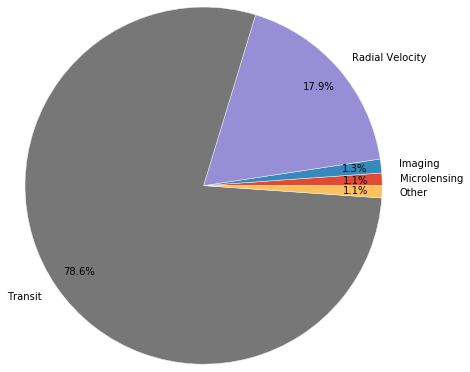

In [9]:
# Group together smaller data so pie chart isn't overwhelming
sub_disc = disc_method[disc_method >= 30]
sub_disc.loc["Other"] = disc_method[disc_method < 30].sum()

# Plot pie chart
ax = sub_disc.plot.pie(autopct="%1.1f%%", pctdistance=.85, radius=2)
ax.set_aspect("equal")  # Make pie a perfect circle

Of the 10 methods that have successfully been used to find planets, 96.5% of discoveries have been made using just two methods: transit and radial velocity.

### Who discovers them?

In [10]:
# Identify the discovery facilities
facilities = discovery.groupby("pl_facility").size().sort_values()

In [11]:
print("Number of exoplanet-discovering facilities: %d" % len(facilities))
print("Number which have discovered more than 5 planets: %d" % len(facilities[facilities > 5]))

Number of exoplanet-discovering facilities: 48
Number which have discovered more than 5 planets: 26


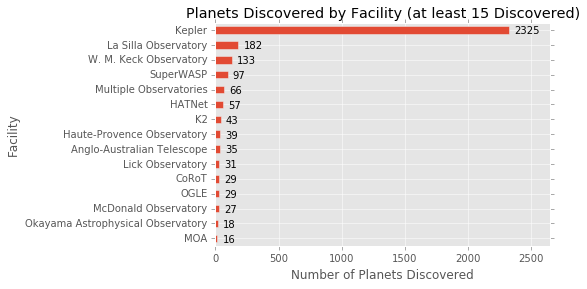

In [12]:
# Only graph facilities which have found at least 15 exoplanets
sub_fac = facilities[facilities >= 15]

# Plot method frequencies
ax = sub_fac.plot.barh()
plt.xlabel("Number of Planets Discovered")
plt.ylabel("Facility")
plt.title("Planets Discovered by Facility (at least 15 Discovered)")
plt.xlim([0, 2650])

# Include count labels on bar graph
for rect, label in zip(ax.patches, sub_fac):
    ax.text(rect.get_width() + 40, rect.get_y(), label)

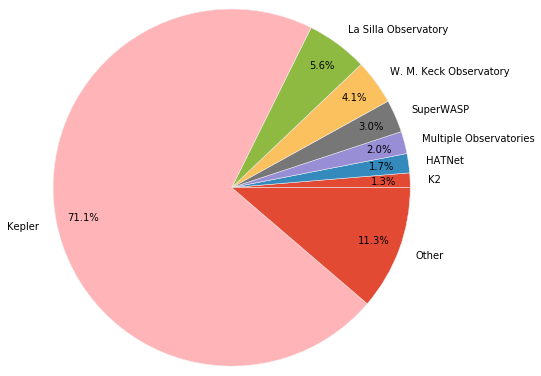

In [13]:
# Group together smaller data so pie chart isn't overwhelming
sub_fac = facilities[facilities >= 40]
sub_fac.loc["Other"] = facilities[facilities < 40].sum()

# Plot pie chart
ax = sub_fac.plot.pie(autopct="%1.1f%%", pctdistance=.85, radius=2)
ax.set_aspect("equal")

The large majority (~71%) of exoplanets so far have been discovered by the Kepler space telescope, almost 13x what was discovered by the next most accomplished facility.

### How flexible are facilities about using multiple discovery methods?

In [14]:
method_counts = discovery[["pl_facility", "pl_discmethod"]].drop_duplicates()
method_counts = method_counts.groupby("pl_facility").size()
method_counts = method_counts.sort_values(ascending=False)

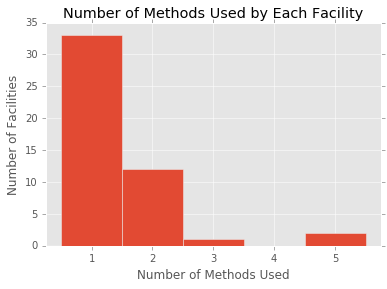

In [15]:
bins = np.arange(method_counts.max() + 2) - 0.5  # To fix x-axis labelling
method_counts.plot.hist(bins)
plt.xlim([.25, method_counts.max() + .75])
plt.xlabel("Number of Methods Used")
plt.ylabel("Number of Facilities")
plt.title("Number of Methods Used by Each Facility")

In [16]:
counts_group = pd.DataFrame(method_counts).reset_index()
counts_group = counts_group.groupby(0).count()

print("Percentage of facilities using just 1 method: %1.1f%%" % (counts_group.ix[1] /
                                                                   counts_group.sum() * 100))
print("Number of facilities using more than 2 methods: %d" % method_counts[method_counts > 2].count())

Percentage of facilities using just 1 method: 68.8%
Number of facilities using more than 2 methods: 3


In [17]:
flexible = pd.DataFrame(method_counts[method_counts > 2]).reset_index()
flexible.columns = ["Facility", "Number of Methods"]
flexible

,Facility,Number of Methods
0,Multiple Observatories,5
1,Kepler,5
2,Hubble Space Telescope,3


Most facilities are not very flexible; over 2/3 of facilities use just one method of discovery.

Only 3 entries use more than two methods. One of those entries represents collaborations between multiple observatories, which is irrelevant for understanding flexibility within each facility individually. This leaves only 2 facilities flexible enough to use a relatively large number of methods:
- Kepler
- Hubble Space Telescope

### Where would we be without Kepler?

The Kepler Space Telescope is the 800-pound gorilla in the room, but there's more to exoplanet discovery than just Kepler. It wasn't even launched until 2009, and there are almost 50 other facilities that have found confirmed exoplanets.

What happens if we ignore Kepler?

In [18]:
# Remove Kepler and K2
not_kepler = discovery[(discovery["pl_facility"] != "Kepler") & (discovery["pl_facility"] != "K2")]

Note: We'll also ignore K2, the second mission of the Kepler Space Telescope, as we want to remove the influence of the entire telescope.

In [19]:
# Analyze the discovery methods
nk_methods = not_kepler.groupby("pl_discmethod").size().sort_values()

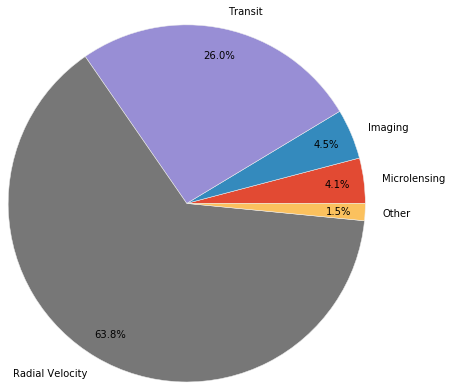

In [20]:
# Group together smaller data so pie chart isn't overwhelming
sub_disc = nk_methods[nk_methods >= 30]
sub_disc.loc["Other"] = nk_methods[nk_methods < 30].sum()

# Plot pie chart
ax = sub_disc.plot.pie(autopct="%1.1f%%", pctdistance=.85, radius=2)
ax.set_aspect("equal")

Turns out Kepler is a *massive* leader for the transit method. Without Kepler in the picture, transit is no longer the most successful method of planetary discovery by a long shot. Radial velocity is now the most productive, with fully twice the success record of transit.

This could be because radial velocity is the oldest successful method, and thus has had the most time to rack up confirmed finds. Radial velocity has been used successfully since 1989, whereas transit didn't complete its first find until 2002.

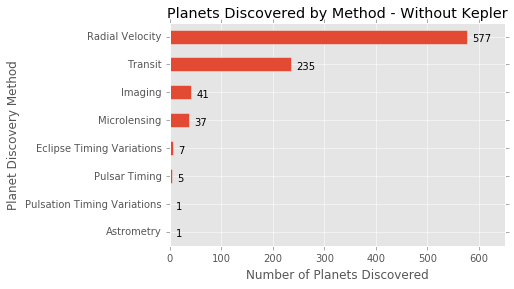

In [21]:
# Plot method frequencies
ax = nk_methods.plot.barh()
plt.xlabel("Number of Planets Discovered")
plt.ylabel("Planet Discovery Method")
plt.title("Planets Discovered by Method - Without Kepler")
plt.xlim([0, 650])

# Include count labels on bar graph
for rect, label in zip(ax.patches, nk_methods):
    ax.text(rect.get_width() + 10, rect.get_y(), label, va="bottom")

Since two methods are now completely missing, it appears Kepler is the only facility to have ever successfully used the transit timing variations or orbital brightness modulation methods to discover a planet.

### Are certain methods more successful at discovering particular types of planets?

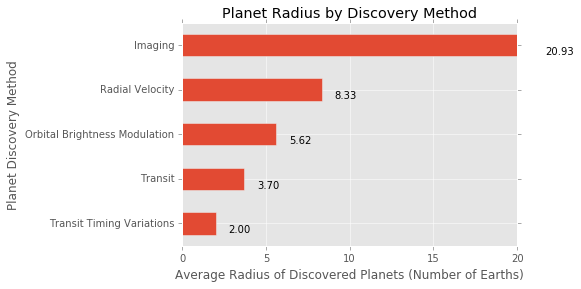

In [22]:
# Calculate average planet radius per method
rad = discovery.dropna()
rad = rad.groupby("pl_discmethod").mean()["pl_rade"].sort_values()

# Plot method frequencies
ax = rad.plot.barh()
plt.xlabel("Average Radius of Discovered Planets (Number of Earths)")
plt.ylabel("Planet Discovery Method")
plt.title("Planet Radius by Discovery Method")
plt.xlim([0, 20])

# Include count labels on bar graph
for rect, label in zip(ax.patches, rad):
    ax.text(rect.get_width() + 0.75, rect.get_y(), ("%1.2f" % label), va="bottom")

As expected, imaging is best at discovering larger planets.

Interestingly, transit generally discovers larger planets than transit timing variations. It's possible that once the first planet is discovered helping find smaller planets.

Note: Some methods are missing because no radius data is available for the planets they've discovered.

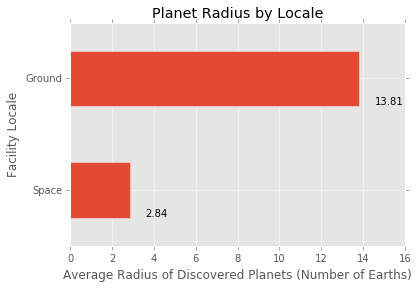

In [23]:
# Calculate average planet radius per facility
rad = discovery.dropna()
rad = rad.groupby("pl_locale").mean()["pl_rade"].sort_values()

# Plot method frequencies
ax = rad.plot.barh()
plt.xlabel("Average Radius of Discovered Planets (Number of Earths)")
plt.ylabel("Facility Locale")
plt.title("Planet Radius by Locale")
plt.xlim([0, 16])

# Include count labels on bar graph
for rect, label in zip(ax.patches, rad):
    ax.text(rect.get_width() + 0.75, rect.get_y(), ("%1.2f" % label), va="bottom")

Also not surprisingly, space telescopes are better at discovering smaller planets than ground-based telescopes. Because space telescopes avoid atmosphere-induced errors, they're more precise, accurate, and consistent than ground-based telescopes.

# Solar Systems

In [24]:
query = url_base + "&table=exoplanets&select=pl_cbflag,pl_pnum,pl_masse"
systems = pd.DataFrame(requests.get(query).json())

### How many planets orbit multiple stars?

In a binary star system, two stars orbit each other. A circumbinary planet is a planet orbiting around both stars in a binary star system.

The most famous example of this in science fiction is, of course, **[Tatooine in Star Wars](https://what-if.xkcd.com/150/)**.

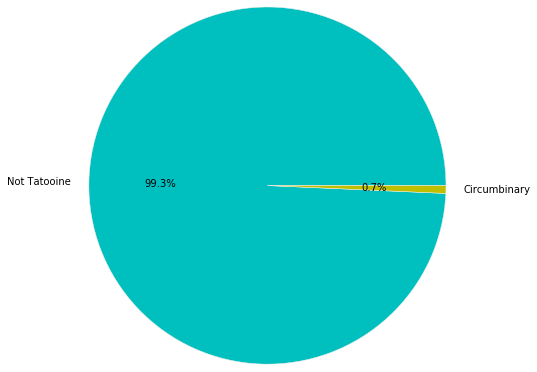

In [25]:
# Get circumbinary counts and set proper index names
circumbinary = systems.groupby("pl_cbflag").size()
circumbinary.index = ["Not Tatooine", "Circumbinary"]

# Plot proportions
ax = circumbinary.plot.pie(autopct="%1.1f%%", colors=["c", "y"], radius=2)
ax.set_aspect("equal")

Due to a lack of granularity in the data set, it's unclear whether the non-circumbinary planets orbit a single star, are in a binary star system that isn't circumbinary, or orbit [even more than 2 stars](https://arxiv.org/abs/1210.3612).

Less than 1% of planets discovered so far are circumbinary. That is, we know of 23 planets currently orbiting binary star systems, and one could potentially be Tatooine. It remains to be seen how many have pod racing.

All jokes aside, it's pretty amazing that examples of this even exist in our galaxy!

### How many planets are in each solar system?

In [26]:
print("Mean number of planets: %1.2f" % systems["pl_pnum"].mean())
print("Percentage of systems with multiple planets: %1.1f%%" % (systems[systems["pl_pnum"] > 1]["pl_pnum"].count()
                                                       / len(systems) * 100))

Mean number of planets: 1.77
Percentage of systems with multiple planets: 42.6%


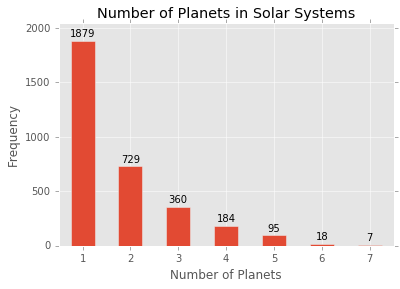

In [27]:
# Get number of planets per solar system
planet_count = systems.groupby("pl_pnum").size()

# Make and format plot
ax = planet_count.plot.bar()
plt.ylim([0, 2050])  # Prevent count labels from getting cut off
plt.xlabel("Number of Planets")
plt.ylabel("Frequency")
plt.title("Number of Planets in Solar Systems")

# Rotate x labels to fix their orientation
for tick in ax.get_xticklabels():
    tick.set_rotation(0)

# Include count labels on bar graph
for rect, label in zip(ax.patches, planet_count):
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height() + 40, label, ha="center")

Almost half of solar systems have multiple planets!

The most we've found in another solar system so far is 7, which is still fewer than the number in our own system. It's likely that this number is low, considering our ability to detect small planets is still limited, and many of the planets in our own system would be too small to discover yet in those distant systems.

Because new planets are constantly being discovered, it's likely that there are many planets yet undiscovered in these solar systems. If true, this would skew the data even more in favor of multiple planets. Considering so many solar systems have numerous planets already, it's likely the majority of systems had multiple planets.

### Is there a correlation between planet size and number of planets?

Can we predict how many planets would be in a solar system using the mass of the planets we know?

Hypothesis: Bigger planets use more material when forming from the planetary nebulae, leading to less material available for other planets to form, and thus fewer planets overall. Alternatively, more planets forming would leave less material available for large planets to form.

In [28]:
# Remove planets without available data on their mass, otherwise linear regression will fail
mass = systems.dropna()

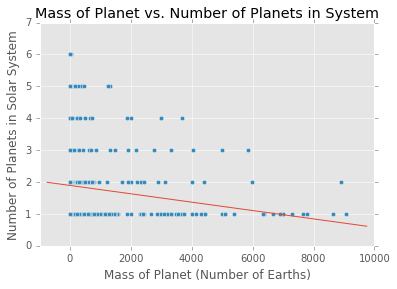

In [29]:
# Create linear regression model and trend line
model = LinearRegression()
model.fit(mass[["pl_masse"]], mass["pl_pnum"])
x_test = np.linspace(-750, 9750, 1000)
y_test = model.predict(pd.DataFrame(x_test))

# Plot data and trend line
mass.plot.scatter(x="pl_masse", y="pl_pnum")
plt.plot(x_test, y_test)

# Format plot
plt.xlim([-1000, 10000])
plt.xlabel("Mass of Planet (Number of Earths)")
plt.ylabel("Number of Planets in Solar System")
plt.title("Mass of Planet vs. Number of Planets in System")

At first glance, it appears there is a possible negative correlation between planetary mass and number of planets. To explore how strong of a correlation there is, I'll try to develop a prediction model with a closer fit. I'll try to use machine learning to generate an improved linear regression prediction model, which will hopefully be able to predict the number of planets in a solar system from planetary mass.

To ensure the model fits the data as well as possible, I'll first find the model with the lowest test error. In predictive modeling, test error represents how correctly a model predicts the data outcome. I'll try raising the input data to various powers to identify which polynomial model has the best fit.

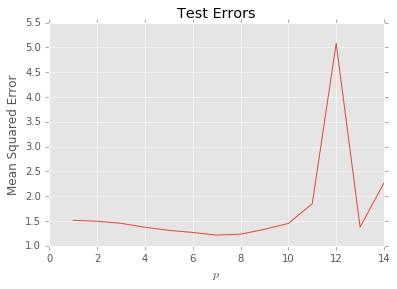

In [30]:
# Set up data
model = LinearRegression()
powers = range(1, 15)
test_errors = []
X = pd.DataFrame()
y = mass["pl_pnum"]

# Scale masses to prevent integer overflow
scaled_mass = scale(mass["pl_masse"])

# Calculate multiple powers
for p in powers:
    # Add next power
    X["x^%d" % p] = scaled_mass ** p
    
    # Calculate test error using cross validation
    test_errors.append(-cross_val_score(model, X, y, cv=10, scoring="mean_squared_error").mean())
    
# Plot errors
plt.plot(powers, test_errors)
plt.xlabel("$p$")
plt.ylabel("Mean Squared Error")
plt.title("Test Errors")

In [31]:
# Find best power
p_good = np.argmin(test_errors) + 1
p_good_str = "x^%d" % p_good
print("Best power: " + p_good_str)

# Remove unecessary powers after finding best power
X = X.ix[:, :p_good_str]

Best power: x^7


After cross-validating various possible polynomial models, x^7 had the lowest test error and thus produced the best fit. We'll move forward with that as the best model.

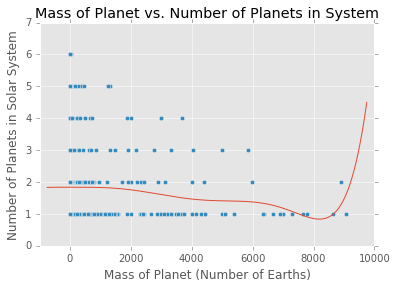

In [32]:
# Recalculate X without scaling
X = pd.DataFrame()
for p in range(1, p_good + 1):
    X["x^%d" % p] = mass["pl_masse"] ** p

# Make model
model = LinearRegression()
model.fit(X, mass["pl_pnum"])

# Create the trend line
x_test = np.linspace(-750, 9750, 1000)
X_test = pd.DataFrame()
for p in range(1, p_good + 1):
    X_test["x^%d" % p] = x_test ** p
y_test = model.predict(X_test)

# Plot data and trend line
mass.plot.scatter(x="pl_masse", y="pl_pnum")
plt.plot(x_test, y_test)

# Format plot
plt.xlim([-1000, 10000])
plt.xlabel("Mass of Planet (Number of Earths)")
plt.ylabel("Number of Planets in Solar System")
plt.title("Mass of Planet vs. Number of Planets in System")

Unfortunately, the model wasn't completely successful at predicting number of planets.

There is a slight negative correlation between mass and number of planets, which would support my hypothesis that bigger planets means fewer planets, and vice-versa. However, the correlation isn't incredibly strong, and the sudden sharp incline one the right of the line is troubling. The model was also unable to predict larger numbers of planets in a solar system.

The model may have failed due to incomplete data (we're still relatively new at finding exoplanets!). Because it's so much more difficult to find smaller planets than larger ones, it's possible we've discovered a larger proportion of the large planets in given solar systems than the small ones, thus biasing the data. Of course, there's also the possibility that there simply isn't a correlation in the first place between planet mass and number of planets. More data is necessary to determine which it is.

Even if the results aren't as exciting as a functional predictive model, showing a lack of a strong relationship is important too.